### Loading the cleaned dataset

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ[categ.vocal_channel=="GNAA"] = np.nan

print(quant.columns)
print(categ.columns)
print(len(categ), len(quant))
display(quant.head())
display(categ.head())

Index(['length_ms', 'mean', 'mfcc_max', 'mfcc_mean', 'mfcc_std', 'sc_kur',
       'sc_max', 'sc_mean', 'sc_min', 'sc_skew', 'sc_std', 'skew', 'stft_kur',
       'stft_mean', 'stft_std', 'zcs', 'log_stft_min'],
      dtype='object')
Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex'],
      dtype='object')
2430 2430


,length_ms,mean,mfcc_max,mfcc_mean,mfcc_std,sc_kur,sc_max,sc_mean,sc_min,sc_skew,sc_std,skew,stft_kur,stft_mean,stft_std,zcs,log_stft_min
0,3737,0.516733,171.69092,-33.485947,134.654860,-1.120769,0.766460,5792.550744,989.262803,0.250940,3328.055457,0.273153,-1.215025,0.415250,0.335533,16995,-3.923782
1,3904,0.492286,205.00770,-29.502108,130.485630,-1.531204,0.476926,5197.620555,1906.869009,0.219582,4040.931570,0.292157,-1.384174,0.417488,0.352380,13906,-3.066872
2,4671,0.576708,165.45653,-30.532463,126.577110,-1.130153,0.479789,4830.743037,1095.943669,0.436699,3332.131300,0.302659,-1.242947,0.379758,0.352270,18723,-4.281826
3,3637,0.509706,190.03609,-36.059555,159.725160,-1.497765,0.494705,5376.446478,883.491592,0.098802,4053.663073,-0.081014,-1.445318,0.407277,0.360552,11617,-3.949556
4,4404,0.535177,161.13400,-31.405996,122.125824,-1.167544,0.486484,5146.012474,877.282487,0.496066,3442.724109,0.414872,-1.366742,0.415974,0.350655,15137,-4.544363


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F


### Normalization

In [3]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler, PowerTransformer
from pandas import DataFrame

scaler = StandardScaler()

X = quant.values
X = scaler.fit_transform(X)

### UMAP

In [4]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
import umap 

X = quant.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=100)
embedding = reducer.fit_transform(X)

SystemError: initialization of _internal failed without raising an exception

In [ ]:
embed_df = pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1]))
embed_cat = embed_df.join(categ)
embed_cat.head()
embed_cat

,x,y,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,5.750168,2.164770,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,5.600580,1.282645,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,7.262632,3.062843,song,happy,strong,Dogs are sitting by the door,2nd,16.0,F
3,4.976320,-0.153838,speech,surprised,normal,Kids are talking by the door,1st,14.0,F
4,7.269697,2.452450,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F
...,...,...,...,...,...,...,...,...,...
2447,2.006167,1.330799,speech,calm,strong,Kids are talking by the door,1st,23.0,M
2448,1.791135,1.164326,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M
2449,2.653644,6.553624,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M
2450,2.303415,2.750863,speech,surprised,normal,Kids are talking by the door,1st,GNAA,M


Text(0, 0.5, '')

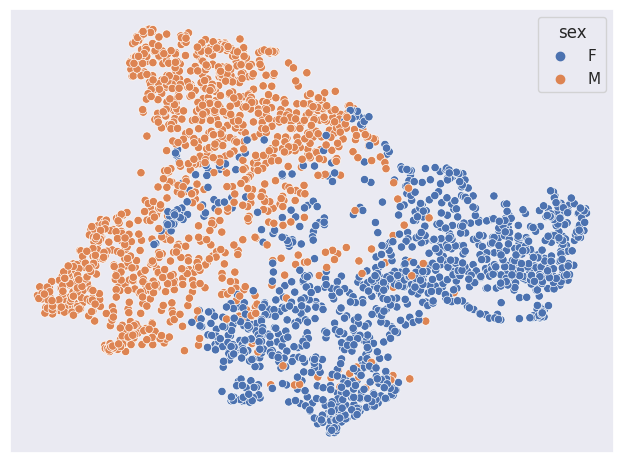

In [ ]:
sns.scatterplot(data=embed_cat,x="x", y="y", hue="sex")
# plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")


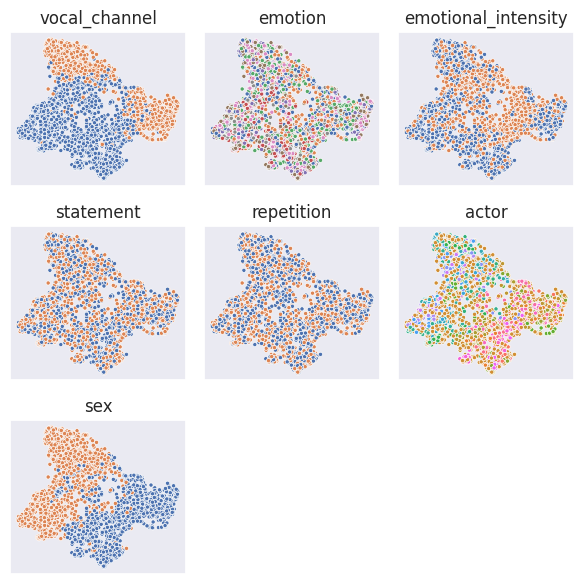

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(M,M))
axes=axes.flatten()

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

for ax, cat in zip(axes, categ.columns):
    sns.scatterplot(data=embed_cat, x="x", y="y", hue=cat, marker=".", ax=ax)
    ax.axis("on")
    ax.set_title(cat)
    ax.get_legend().remove()

fig.savefig("UMAP_categ.pdf")

We drop the analysis of `repetition`, `actor` and `statement` by now

## ISOMAP and Minkowski _p_

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


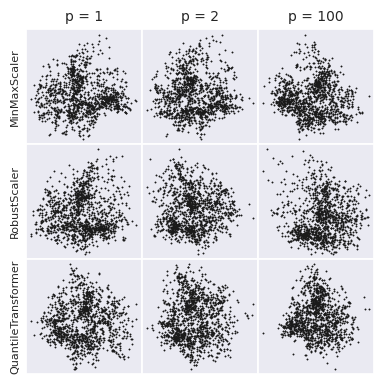

In [5]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.manifold import Isomap

scalers = [MinMaxScaler(), RobustScaler(), QuantileTransformer(output_distribution='normal')]
ps = [1, 2, 100]

fig, axes = plt.subplots(len(scalers),len(ps), figsize=(4,4),gridspec_kw = {'wspace':0, 'hspace':0})

for i, scaler in enumerate(scalers):
    for j, p in enumerate(ps):
        X = quant.values
        X = scaler.fit_transform(X)
        S = Isomap(n_neighbors=3, p=p).fit_transform(X)
        # sns.kdeplot(x=S[:,0], y=S[:,1], ax=axes[i,j], linewidths=np.linspace(0,1,20)**2)
        who = (np.random.uniform(0,1, size=len(S)) > 0.5)
        sns.scatterplot(x=S[who, 0], y=S[who,1], ax=axes[i,j], s=5, edgecolor=None, marker=".", color="k")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if j == 0:
            axes[i,j].set_ylabel(str(scaler.__class__).split(".")[-1][:-2], font={"size":8})
        if i==0:
            axes[i,j].set_title(f"p = {p}", font={"size":10})
        # axes[i,j].axis("off")
plt.savefig("isomap_tests.pdf")
plt.show()

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import Isomap

X = MinMaxScaler().fit_transform(quant.values)#  MinMaxScaler().fit_transform(quant.values)
missing_vc_filter = np.logical_not(categ.vocal_channel.isna())
S = Isomap(n_neighbors=3, p=100).fit_transform(X)
classes = [f"{s}-{v}" for v, s in zip(categ.vocal_channel, categ.sex)]

unique_classes = np.unique(classes)
map_classes = {c:i for c,i in zip(unique_classes, range(6))}
codes = [map_classes[cl] for cl in classes]
print(codes[:20])
classifier = KNeighborsClassifier(n_neighbors=23).fit(S, codes)
print(map_classes)

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(
/tmp/ipykernel_77176/3537155488.py:10: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=S[:,0], y=S[:,1], marker="s", s=7, zorder=10, alpha=1, hue=codes, palette=colors, edgecolor=None)


(-1.0, 1.0)

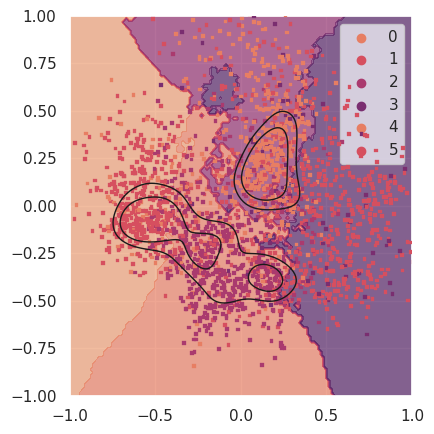

In [15]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(figsize=(4.5,4.5))
colors = sns.color_palette(palette="flare", n_colors=4)
cmap = sns.color_palette(palette="flare", n_colors=4, as_cmap=True)

dbd = DecisionBoundaryDisplay.from_estimator(classifier, S, response_method="predict", grid_resolution=400, alpha=.7, ax=ax, eps=2, cmap=cmap)

sns.kdeplot(x=S[:,0], y=S[:,1], marker=".", color="k", linestyles="-", fill=False, alpha=1, levels=np.linspace(0.6,1,3),linewidths=1, ax=ax, zorder=20, bw_adjust=0.8)
sns.scatterplot(x=S[:,0], y=S[:,1], marker="s", s=7, zorder=10, alpha=1, hue=codes, palette=colors, edgecolor=None)
# sns.scatterplot(x=S[:,0], y=S[:,1], marker="s", s=4, color="k", zorder=11, alpha=0.1 , edgecolor=None)
M = 1
plt.xlim(-M, M)
plt.ylim(-M,M)

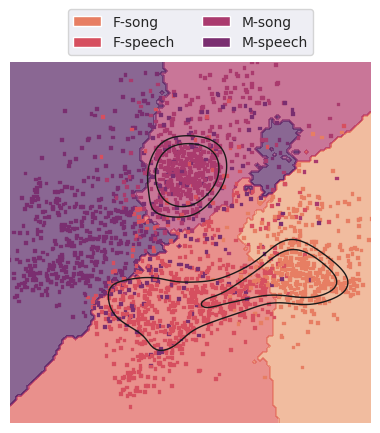

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
unique_classes = np.unique(classes)
legend_elements = [Patch(facecolor=colors[0], label=unique_classes[0]),
                     Patch(facecolor=colors[1], label=unique_classes[1]),
                     Patch(facecolor=colors[2], label=unique_classes[2]),
                     Patch(facecolor=colors[3], label=unique_classes[3])]

ax.legend(handles=legend_elements, loc='lower center', fontsize=10, bbox_to_anchor=(0.5, 1), ncols=2)
# centers = np.array([[-.8,2.9], [3, -1]]).T
# ax.scatter(centers[0], centers[1], marker="X", color="k",s=50)

# centers = np.array([[-3.5,-0.5], [0.2, -2.2]]).T
# ax.scatter(centers[0], centers[1], marker="^", color="k",s=50)

# lines = [ [[-6, -4], [-10, -5]], 
#           [[4,   8], [-3,  -8]], 
#           [[-7, -5], [4,    -1]],
#           [[-3,  2], [-3,   -2]]
#           ]

# for line in lines:
#     ax.plot(line[0], line[1], ls="--", color="k", lw=0.8)

ax.axis("off")
ax.set_aspect("equal")
fig.tight_layout()
display(fig)
fig.savefig("isomap_kde.pdf")

/tmp/ipykernel_9476/440292129.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=xx[:,0], y=xx[:,1], hue=c, s=32*(s-min(s)), alpha=0.5, marker="s", palette="flare", ax=ax)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/tmp/ipykernel_9476/440292129.py:34: UserWarning: No contour levels were found within the data range.
  ax.contour(x0_axis_range, x1_axis_range,


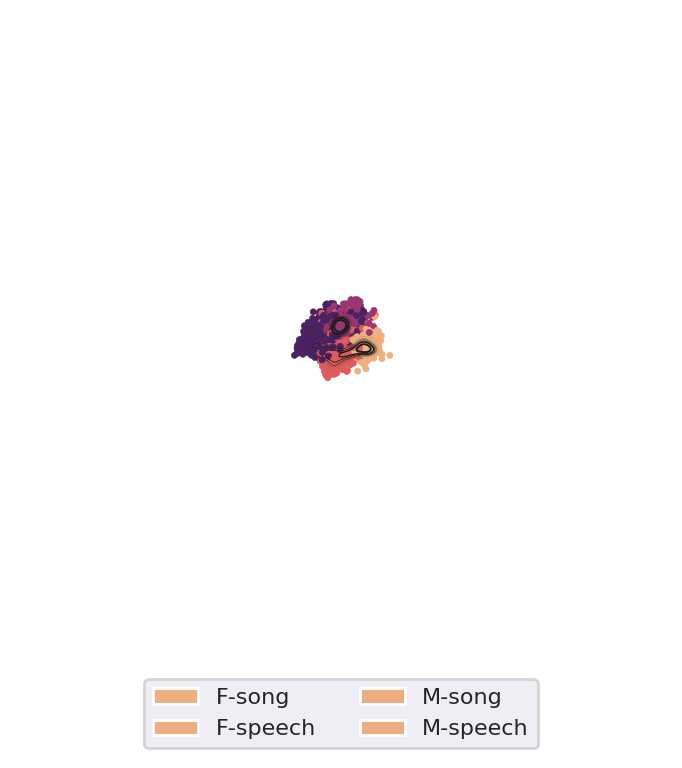

In [ ]:
unique_classes = np.unique(classes)
map_classes = {c:i for c,i in zip(unique_classes, range(4))}
get_codes = lambda x: np.vectorize(map_classes.get)(x)

codes = get_codes(classes)
xscale, yscale =8,8

x0_axis_range = np.linspace(-xscale,xscale, 50)
x1_axis_range = np.linspace(-yscale,yscale, 50)

xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)

xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))

c = get_codes(classifier.predict(xx)) # prediction of all the little dots
s = np.max(classifier.predict_proba(xx), axis=1)

fig, ax = plt.subplots(figsize=(4,4), dpi=200)
sns.scatterplot(x=xx[:,0], y=xx[:,1], hue=c, s=32*(s-min(s)), alpha=0.5, marker="s", palette="flare", ax=ax)
sns.scatterplot(x=S[:,0], y=S[:,1], s=5, hue=codes, palette="flare", edgecolor=None, ax=ax, alpha=1)
sns.kdeplot(x=S[:,0], y=S[:,1],color="k", fill=False, linewidths=np.linspace(0,1,10)**3, alpha=1, levels=np.linspace(0,1,10), zorder=20, ax=ax, common_norm=False)
# sns.kdeplot(x=S[:,0], y=S[:,1],color="k", fill=True,  alpha=1, levels=np.linspace(0,1,10), zorder=-20, ax=ax)

# plt.xlim(-1.2, 1.2)
# plt.ylim(-1.2,1.2)
legend_elements = [Patch(facecolor=cmap(0), label=unique_classes[0]),
                     Patch(facecolor=cmap(1), label=unique_classes[1]),
                     Patch(facecolor=cmap(2), label=unique_classes[2]),
                     Patch(facecolor=cmap(3), label=unique_classes[3])]

ax.legend(handles=legend_elements, loc='center', fontsize=8, bbox_to_anchor=(0.5, -0.08), ncols=2)
ax.set_aspect("equal")

ax.contour(x0_axis_range, x1_axis_range, 
           np.reshape(c,(xx0.shape[0],-1)), 
           levels=[0.1,1.1,2.1,3.1], linewidths=0.3, colors="k")

ax.axis("off")
fig.savefig("isomap_kde_2.png")